In [69]:
import pandas as pd


df = pd.read_csv('compiled_optimization_data.csv')
BO_cols = ['sample','beta','conductivity_avg','DMSO_content_realized','concentration_realized','combustion_temp_realized','air_flow_rate_realized','spray_flow_rate_realized','spray_height_realized','num_passes_realized']
BO_data = df[BO_cols]
BO_data['scaled_conductivity_avg'] = BO_data['conductivity_avg'] * 1e-6 # Scaling the conductivity as it is reported in the paper
display(BO_data)

features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

target = 'scaled_conductivity_avg' # Using the scaled as y

# Data processcing
X = BO_data[features]
y = BO_data[target]

/var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_9872/372676465.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BO_data['scaled_conductivity_avg'] = BO_data['conductivity_avg'] * 1e-6 # Scaling the conductivity as it is reported in the paper


,sample,beta,conductivity_avg,DMSO_content_realized,concentration_realized,combustion_temp_realized,air_flow_rate_realized,spray_flow_rate_realized,spray_height_realized,num_passes_realized,scaled_conductivity_avg
0,0,random,1.749261e+06,0.303015,0.016717,275.376821,77.257211,0.006671,17.859245,8.0,1.749261
1,1,random,1.848613e+06,0.316566,0.016290,271.445423,77.257211,0.006671,17.859245,8.0,1.848613
2,2,random,1.156030e+06,0.110944,0.015141,247.327137,94.389907,0.004694,18.015901,5.0,1.156030
3,3,random,1.267199e+06,0.102290,0.015162,249.043556,94.389907,0.004694,18.015901,5.0,1.267199
4,4,random,0.000000e+00,0.142058,0.014216,227.253349,65.455738,0.002899,21.505628,4.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
172,175,4.00E+02,8.775937e+05,0.124872,0.010071,226.501728,100.000000,0.002000,10.000000,1.0,0.877594
173,176,4.00E+02,1.089103e+06,0.126204,0.009938,230.296026,100.000000,0.002000,10.000000,1.0,1.089103
174,177,SF,0.000000e+00,0.160652,0.019693,289.655893,92.976613,0.007983,18.878692,10.0,0.000000
175,178,SF,0.000000e+00,0.162428,0.019463,289.378096,92.976613,0.007983,18.878692,10.0,0.000000


## Hypothesis testing
- t-test
- permutation test

In [10]:
BO_data['beta'].unique()

random = BO_data[BO_data['beta'] == 'random']['scaled_conductivity_avg']
space_fill = BO_data[BO_data['beta'] == 'SF']['scaled_conductivity_avg']
UCB_0_2 = BO_data[BO_data['beta'] == '2.00E-01']['scaled_conductivity_avg']
UCB_20 = BO_data[BO_data['beta'] == '2.00E+01']['scaled_conductivity_avg']
UCB_400 = BO_data[BO_data['beta'] == '4.00E+02']['scaled_conductivity_avg']

In [28]:
from scipy.stats import ttest_ind
comparisons = [
    ('SF', space_fill),
    ('2.00E-01', UCB_0_2),
    ('2.00E+01', UCB_20),
    ('4.00E+02', UCB_400)
]

# Perform t-test for each comparison
ttest_results = []
for label, group in comparisons:
    t_stat, p_value = ttest_ind(group, random, alternative='greater')
    ttest_results.append({
        'Comparison': f'{label} vs random',
        't-statistic': round(t_stat, 2),
        'p-value': round(p_value, 4)
    })

# Create a DataFrame to store the results
results_df = pd.DataFrame(ttest_results)

# Display the results
print(results_df)

           Comparison  t-statistic  p-value
0        SF vs random        -1.32   0.9048
1  2.00E-01 vs random        11.42   0.0000
2  2.00E+01 vs random        12.73   0.0000
3  4.00E+02 vs random         1.21   0.1151


In [13]:
import numpy as np

def permutation_test_max(group1_label, group2_label, n_permutations=10000, df=BO_data):
    X = df[df['beta'] == group1_label][['scaled_conductivity_avg']].to_numpy()
    Y = df[df['beta'] == group2_label][['scaled_conductivity_avg']].to_numpy()

    np.random.seed(0)
    combined = np.concatenate([X, Y])
    n = len(X)
    obs_diff = np.max(X) - np.max(Y)
    
    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        X_permuted = combined[:n]
        Y_permuted = combined[n:]
        max_diff = np.max(X_permuted) - np.max(Y_permuted)
        perm_diffs.append(max_diff)
    
    # Calculate the p-value
    p_value = np.mean(perm_diffs > obs_diff)
    
    return np.array(perm_diffs), obs_diff, p_value

In [15]:
random_label = 'random'
comparisons = ['SF', '2.00E-01', '2.00E+01', '4.00E+02']

perm_results = []

# Run permutation test for each comparison
for comp in comparisons:
    perm_diffs, obs_diff, p_value = permutation_test_max(group1_label=comp, group2_label=random_label, n_permutations=10000)
    perm_results.append({
        'Comparison': f'{comp} vs random',
        'Observed Max Difference': round(obs_diff, 3),
        'p-value': round(p_value, 4)
    })

perm_results_df = pd.DataFrame(perm_results)
print(perm_results_df)

           Comparison  Observed Max Difference  p-value
0        SF vs random                    0.004   0.3608
1  2.00E-01 vs random                    0.994   0.0000
2  2.00E+01 vs random                    0.812   0.0000
3  4.00E+02 vs random                   -0.003   0.5592


## VARS

In [31]:
from varstool import DVARS
vars_data = BO_data.drop(columns=['sample','beta','conductivity_avg'])
display(vars_data)


display(vars_data)
vars_data.to_csv('vars_data.csv', index=False)
h = 0.5
experiment = DVARS(data_file = 'vars_data.csv',
                   outvarname = 'scaled_conductivity_avg',
                   ivars_range = h,
                   phi0=1,
                   phi_max=1e6,
                   tol = 1e-6,
                   correlation_func_type='linear',
                   report_verbose=False)

experiment.run()
display(experiment.ratios)

,DMSO_content_realized,concentration_realized,combustion_temp_realized,air_flow_rate_realized,spray_flow_rate_realized,spray_height_realized,num_passes_realized,scaled_conductivity_avg
0,0.303015,0.016717,275.376821,77.257211,0.006671,17.859245,8.0,1.749261
1,0.316566,0.016290,271.445423,77.257211,0.006671,17.859245,8.0,1.848613
2,0.110944,0.015141,247.327137,94.389907,0.004694,18.015901,5.0,1.156030
3,0.102290,0.015162,249.043556,94.389907,0.004694,18.015901,5.0,1.267199
4,0.142058,0.014216,227.253349,65.455738,0.002899,21.505628,4.0,0.000000
...,...,...,...,...,...,...,...,...
172,0.124872,0.010071,226.501728,100.000000,0.002000,10.000000,1.0,0.877594
173,0.126204,0.009938,230.296026,100.000000,0.002000,10.000000,1.0,1.089103
174,0.160652,0.019693,289.655893,92.976613,0.007983,18.878692,10.0,0.000000
175,0.162428,0.019463,289.378096,92.976613,0.007983,18.878692,10.0,0.000000


,DMSO_content_realized,concentration_realized,combustion_temp_realized,air_flow_rate_realized,spray_flow_rate_realized,spray_height_realized,num_passes_realized,scaled_conductivity_avg
0,0.303015,0.016717,275.376821,77.257211,0.006671,17.859245,8.0,1.749261
1,0.316566,0.016290,271.445423,77.257211,0.006671,17.859245,8.0,1.848613
2,0.110944,0.015141,247.327137,94.389907,0.004694,18.015901,5.0,1.156030
3,0.102290,0.015162,249.043556,94.389907,0.004694,18.015901,5.0,1.267199
4,0.142058,0.014216,227.253349,65.455738,0.002899,21.505628,4.0,0.000000
...,...,...,...,...,...,...,...,...
172,0.124872,0.010071,226.501728,100.000000,0.002000,10.000000,1.0,0.877594
173,0.126204,0.009938,230.296026,100.000000,0.002000,10.000000,1.0,1.089103
174,0.160652,0.019693,289.655893,92.976613,0.007983,18.878692,10.0,0.000000
175,0.162428,0.019463,289.378096,92.976613,0.007983,18.878692,10.0,0.000000


,DMSO_content_realized,concentration_realized,combustion_temp_realized,air_flow_rate_realized,spray_flow_rate_realized,spray_height_realized,num_passes_realized
0.5,0.302439,0.294266,0.118195,0.027365,0.049267,0.150599,0.05787


ARD

In [306]:
import torch
import botorch as bo
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval

# Features and target variable
features = ['DMSO_content_realized', 'concentration_realized',
            'combustion_temp_realized', 'air_flow_rate_realized',
            'spray_flow_rate_realized', 'spray_height_realized', 'num_passes_realized']

target = 'scaled_conductivity_avg'  # Target variable (scaled)

# Data processing: normalize X, standardize y
X = BO_data[features]
y = BO_data[target]
std = 1e-4

X_tensor = torch.tensor(X.values, dtype=torch.double)
y_tensor = torch.tensor(y.values, dtype=torch.double)

X_full = X_tensor
Y_full = y_tensor
train_Yvar = torch.full_like(Y_full.unsqueeze(-1), std)

X_normed = (X_tensor - X_tensor.min()) / (X_tensor.max() - X_tensor.min()) # Norm to (0,1)
Y_normed = (y_tensor - y_tensor.mean()) / y_tensor.std() # N(0,1)
likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1))  # Noise constraints (1e-8, 1e-3)
model = bo.models.SingleTaskGP(X_normed, Y_normed.unsqueeze(-1), likelihood=likelihood)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Interval(1.000E-08, 1.000E+00)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): Interval(1.000E-08, 1.000E+00)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [307]:
lengthscales = model.covar_module.base_kernel.lengthscale.squeeze().cpu().detach().numpy()
rel_ARD = np.zeros(7)
rel_ARD += 1 / lengthscales
rel_ARD_nor = rel_ARD/np.max(rel_ARD)
print(rel_ARD)
print(rel_ARD_nor)

[ 3.00925864  2.99957134 10.42737031  2.18382149  2.99955015 59.74759796
  2.73336783]
[0.05036619 0.05020405 0.17452367 0.03655078 0.05020369 1.
 0.04574858]


### Plots

In [353]:
import torch
import botorch as bo
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval
from gpytorch.kernels import RBFKernel, MaternKernel

# Helper functions for scaling 
def scale_to_01(values, min_val, max_val):
    return (values - min_val) / (max_val - min_val)

def scale_back(values, min_val, max_val):
    return values * (max_val - min_val) + min_val

def denormalize(y_normalized, mean_y, std_y):
    return y_normalized * std_y + mean_y

def denormalize_std(std_normalized, min_val, max_val):
    scale_factor = max_val - min_val

    return std_normalized * scale_factor



# Fitting the model
X = BO_data[features]
y = BO_data[target]
X_tensor = torch.tensor(X.values, dtype=torch.double)
y_tensor = torch.tensor(y.values, dtype=torch.double)

X_normed = (X_tensor - X_tensor.min()) / (X_tensor.max() - X_tensor.min()) # Send to unit cube [0,1]
Y_normed = (y_tensor - y_tensor.mean()) / y_tensor.std() # Norm to N(0,1)

std = torch.std(Y_normed)  # Estimate the standard deviation from the training data
train_Yvar = torch.full_like(Y_normed.unsqueeze(-1), std)
print(std)
std = 1e-4
train_Yvar = torch.full_like(Y_normed.unsqueeze(-1), std)

model = bo.models.SingleTaskGP(X_normed, Y_normed.unsqueeze(-1))
likelihood = GaussianLikelihood()  # Noise constraints (1e-8, 1e-3)
model = bo.models.SingleTaskGP(X_normed, Y_normed.unsqueeze(-1),likelihood=likelihood)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll) # Train the model

tensor(1.0000, dtype=torch.float64)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): FlexibleGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (raw_lengthscale_constraint): Interval(1.000E-03, 1.000E+02)
    )
  )
)

In [354]:
import torch
# Generate data for plotting

constant_features_T = {
    'DMSO_content_realized': 0.299565,
    'concentration_realized': 0.017578,
    'combustion_temp_realized': 263.492945,
    'air_flow_rate_realized': 91.840492,
    'spray_flow_rate_realized': 0.004712,
    'spray_height_realized': 10.323451,
    'num_passes_realized': 7.0
}

constant_features = {
    'DMSO_content_realized': 1,
    'concentration_realized': 1,
    'combustion_temp_realized': 0.44875,
    'air_flow_rate_realized': 0.937,
    'spray_flow_rate_realized': 0.133,
    'spray_height_realized': 0,
    'num_passes_realized': 0.667
}
# Ranges
ranges_T = {
    'DMSO_content_realized': (0, 0.3),
    'concentration_realized': (0.01, 0.02),
    'combustion_temp_realized': (220, 300),
    'air_flow_rate_realized': (65, 100),
    'spray_flow_rate_realized': (0.002, 0.008),
    'spray_height_realized': (10, 25),
    'num_passes_realized': (1, 10)
}
ranges = {
    'DMSO_content_realized': (0, 1),
    'concentration_realized': (0, 1),
    'combustion_temp_realized': (0, 1),
    'air_flow_rate_realized': (0, 1),
    'spray_flow_rate_realized': (0, 1),
    'spray_height_realized': (0, 1),
    'num_passes_realized': (0, 1)
}

tensors = []


constant_values = torch.tensor(list(constant_features.values()), dtype=torch.float32)
for feature in constant_features:
    tensor = constant_values.repeat(100, 1)
    feature_idx = list(constant_features.keys()).index(feature)
    tensor[:, feature_idx] = torch.linspace(ranges[feature][0], ranges[feature][1], 100)
    tensors.append(tensor)

tensors = torch.stack(tensors)
DMSO_test_tensor = tensors[0]  # Output: (7, 100, 7)
print(DMSO_test_tensor)

tensor([[0.0000, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.0101, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.0202, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.0303, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.0404, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.0505, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.0606, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.0707, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.0808, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.0909, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.1010, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.1111, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.1212, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.1313, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0.1414, 1.0000, 0.4487, 0.9370, 0.1330, 0.0000, 0.6670],
        [0

1.6008730374543276
1.5127133581258596
tensor([0.0000, 0.0030, 0.0061, 0.0091, 0.0121, 0.0152, 0.0182, 0.0212, 0.0242,
        0.0273, 0.0303, 0.0333, 0.0364, 0.0394, 0.0424, 0.0455, 0.0485, 0.0515,
        0.0545, 0.0576, 0.0606, 0.0636, 0.0667, 0.0697, 0.0727, 0.0758, 0.0788,
        0.0818, 0.0848, 0.0879, 0.0909, 0.0939, 0.0970, 0.1000, 0.1030, 0.1061,
        0.1091, 0.1121, 0.1152, 0.1182, 0.1212, 0.1242, 0.1273, 0.1303, 0.1333,
        0.1364, 0.1394, 0.1424, 0.1455, 0.1485, 0.1515, 0.1545, 0.1576, 0.1606,
        0.1636, 0.1667, 0.1697, 0.1727, 0.1758, 0.1788, 0.1818, 0.1848, 0.1879,
        0.1909, 0.1939, 0.1970, 0.2000, 0.2030, 0.2061, 0.2091, 0.2121, 0.2152,
        0.2182, 0.2212, 0.2242, 0.2273, 0.2303, 0.2333, 0.2364, 0.2394, 0.2424,
        0.2455, 0.2485, 0.2515, 0.2545, 0.2576, 0.2606, 0.2636, 0.2667, 0.2697,
        0.2727, 0.2758, 0.2788, 0.2818, 0.2848, 0.2879, 0.2909, 0.2939, 0.2970,
        0.3000])
[[0.84276539]
 [0.84276539]
 [0.84276539]
 [0.84276539]
 [0.84276

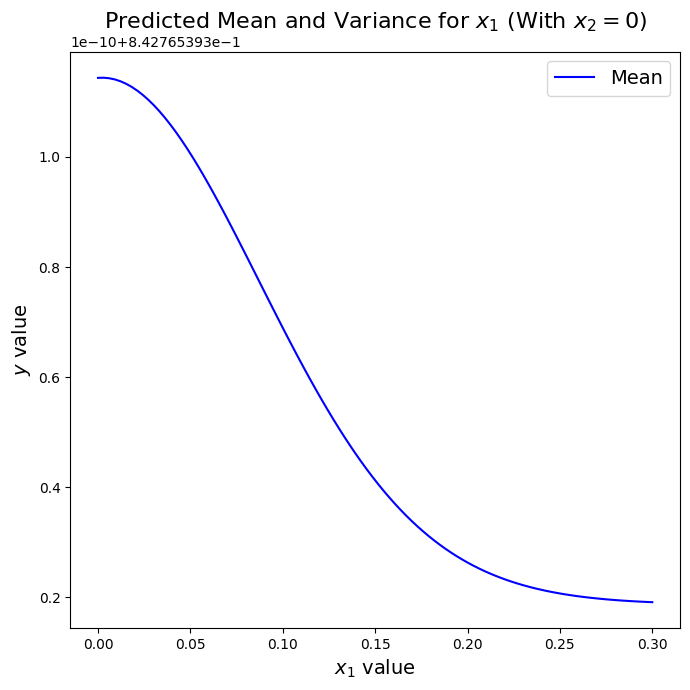

In [355]:
import matplotlib.pyplot as plt

min_y = BO_data['scaled_conductivity_avg'].min()
max_y = BO_data['scaled_conductivity_avg'].max()
mean_y = BO_data['scaled_conductivity_avg'].mean()
std_y = BO_data['scaled_conductivity_avg'].std()
print(mean_y)
print(std_y)

model.eval()
with torch.no_grad():
    predictions_x1 = model.posterior(DMSO_test_tensor)
    mean_x1 = predictions_x1.mean.detach().numpy()
    variance_x1 = predictions_x1.variance.detach().numpy()
    std_x1 = np.sqrt(variance_x1)

# Rescale
x1 = DMSO_test_tensor[:, 0].view(1, 100).squeeze()
x1_test_points_orig = scale_back(x1, 0, 0.3)
print(x1_test_points_orig)
std = denormalize_std(std_x1, min_y, max_y)
mean = denormalize(mean_x1, mean_y, std_y)
print(mean)
lower = (mean-std).squeeze()
upper = (mean+std).squeeze()

plt.figure(figsize=(7, 7))
plt.plot(x1_test_points_orig, mean, 'b-', label='Mean')
# plt.fill_between(x1_test_points_orig, lower, upper, color='b', alpha=0.2, label='Std Dev')
plt.title('Predicted Mean and Variance for $x_1$ (With $x_2=0$)', fontsize=16)
plt.xlabel('$x_1$ value', fontsize=14)
plt.ylabel('$y$ value', fontsize=14)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()